# The following notebook includes:
* Was used dataset from raw audio files in flac format from the corpus with audiobooks (clean speech) 
* Feature extraction made using our approach of R-package 'process_input.py'
* Tried MLP network from the article
* Tried other ML algorithms with tuning parameters
* Used feature importance to reduce some features, compared results with and without feature reduction

In [1]:
import pandas as pd
import numpy as np
from functools import reduce
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
try:
    full_data = pd.read_csv('Audiobooks_data.csv')
except FileNotFoundError:
    from process_input import make_csv_from_audios
    make_csv_from_audios(speakers_file='Libri_Speakers.txt', audios_directory='LibriSpeech_audio', 
                         to_csv_file='Audiobooks_data.csv')
    full_data = pd.read_csv('Audiobooks_data.csv')

##### Ready dataset

In [3]:
full_data.shape

(1166, 23)

In [4]:
from sklearn.utils import shuffle
shuffled = shuffle(full_data, random_state = 0) #in case there are lots of males or females in sequence in dataset

In [5]:
X_shuffled = shuffled.drop(['id', 'sex'], axis=1)
y = shuffled.sex

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X_shuffled)

##### Classes 'male'  = 1 and 'female' = 0  have quiet equal number of samples $\Rightarrow$ classes are balanced $\Rightarrow$' accuracy' metric will be used

In [7]:
print ('Number male samples is',sum(y == 1))
print ('Number female samples is',sum(y == 0))

Number male samples is 602
Number female samples is 564


##### MLP network from the article

In [8]:
state = np.random.get_state()
np.random.seed(42)
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Nadam
from sklearn.model_selection import StratifiedKFold

Using TensorFlow backend.
/Users/victory/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [9]:
y = to_categorical(y, 2)

In [10]:
def neural_network():
    x_input = Input(shape=(21,))

    hidden1 = Dense(units=64, activation='tanh')(x_input)
    hidden1 = Dropout(0.25)(hidden1)
    hidden2 = Dense(units=256, activation='tanh')(hidden1)
    hidden2 = Dropout(0.25)(hidden2)
    hidden3 = Dense(units=256, activation='tanh')(hidden2)
    hidden3 = Dropout(0.25)(hidden3)
    hidden4 = Dense(units=64, activation='tanh')(hidden3)

    y_output = Dense(units=2, activation='softmax')(hidden4)

    model = Model(inputs=x_input, outputs=y_output)
    model.compile(loss='kullback_leibler_divergence', optimizer=Nadam(lr=1e-3), metrics=['accuracy'])
    
    return model

In [11]:
kFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
epochs = 150
batch_size = 32

scores = []
for train, test in kFold.split(X, y[:, 0]):
    model = neural_network()
    model.fit(X[train], y[train], 
              validation_data=(X[test], y[test]), 
              epochs=epochs, batch_size=batch_size, verbose=0)
    score = model.evaluate(X[test], y[test], verbose=0)
    print('Accuracy: {:.3f}'.format(score[1]))
    scores.append(score[1])
print('Neural network: {:.3f}±{:.3f}'.format(np.mean(scores), np.std(scores)))
np.random.set_state(state)

Accuracy: 0.838
Accuracy: 0.838
Accuracy: 0.854
Accuracy: 0.768
Accuracy: 0.836
Neural network: 0.827±0.030


##### This score is lower, than score of this MLP on dataset from the article

##### Now, trying other ML algorithms to solve the problem (algorithms mentioned in the article, but authors did not conduct the experiment)

In [12]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.learning_curve import validation_curve

/Users/victory/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/victory/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


##### Firstly, we decided to check workability of models on cross validation 

In [13]:
X = pd.DataFrame(X, columns = X_shuffled.columns)
y = shuffled.sex

In [14]:
def cross_val_model(model, X, y, verbose=2):
    cv = KFold(n_splits=5)
    scores = cross_val_score(model, X, y, cv=cv, verbose=verbose, scoring='accuracy')
    print('{}: {:.3f}±{:.3f}'.format(model.__class__.__name__, np.mean(scores), np.std(scores)))

In [15]:
boost = GradientBoostingClassifier(random_state = 42)
cross_val_model(boost, X, y, 0)

GradientBoostingClassifier: 0.851±0.022


In [16]:
forest = RandomForestClassifier(random_state = 42)
cross_val_model(forest, X, y, 0)

RandomForestClassifier: 0.813±0.021


In [17]:
svm = SVC(random_state = 42, probability=True)
cross_val_model(svm, X, y, 0)

SVC: 0.802±0.026


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
#Stacked model: forest+svc+boosting --> boosting --> output
forest.fit(X_train, y_train)
svm.fit(X_train, y_train)
boost.fit(X_train, y_train)
combo = pd.DataFrame({'forest': forest.predict_proba(X_test)[:, 1], 
                      'svm': svm.predict_proba(X_test)[:, 1], 
                      'boost': boost.predict_proba(X_test)[:, 1]})
cross_val_model(boost, combo, y_test, 0)

GradientBoostingClassifier: 0.857±0.037


##### Feature importance

Feature ranking:
1. feature 6 (0.247663)
2. feature 12 (0.144065)
3. feature 16 (0.097728)
4. feature 7 (0.061481)
5. feature 19 (0.054021)
6. feature 1 (0.034910)
7. feature 8 (0.034289)
8. feature 13 (0.033350)
9. feature 5 (0.031271)
10. feature 10 (0.031113)
11. feature 17 (0.029953)
12. feature 3 (0.028755)
13. feature 15 (0.027081)
14. feature 0 (0.027000)
15. feature 4 (0.026654)
16. feature 18 (0.026220)
17. feature 20 (0.022777)
18. feature 2 (0.021020)
19. feature 11 (0.020379)
20. feature 14 (0.000271)
21. feature 9 (0.000000)


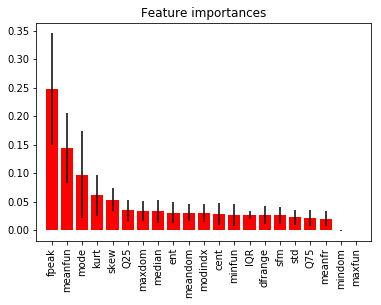

In [20]:
forest = RandomForestClassifier(random_state = 42)

forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
names = [X_train.columns[index] for index in indices]
# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), names, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [21]:
import seaborn as sn
def see_correlations(X, y):
    df_cm = pd.concat([y, X], axis=1).corr()
    plt.figure(figsize = (16,16))
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, fmt='.2g', annot=True, annot_kws={"size": 12})

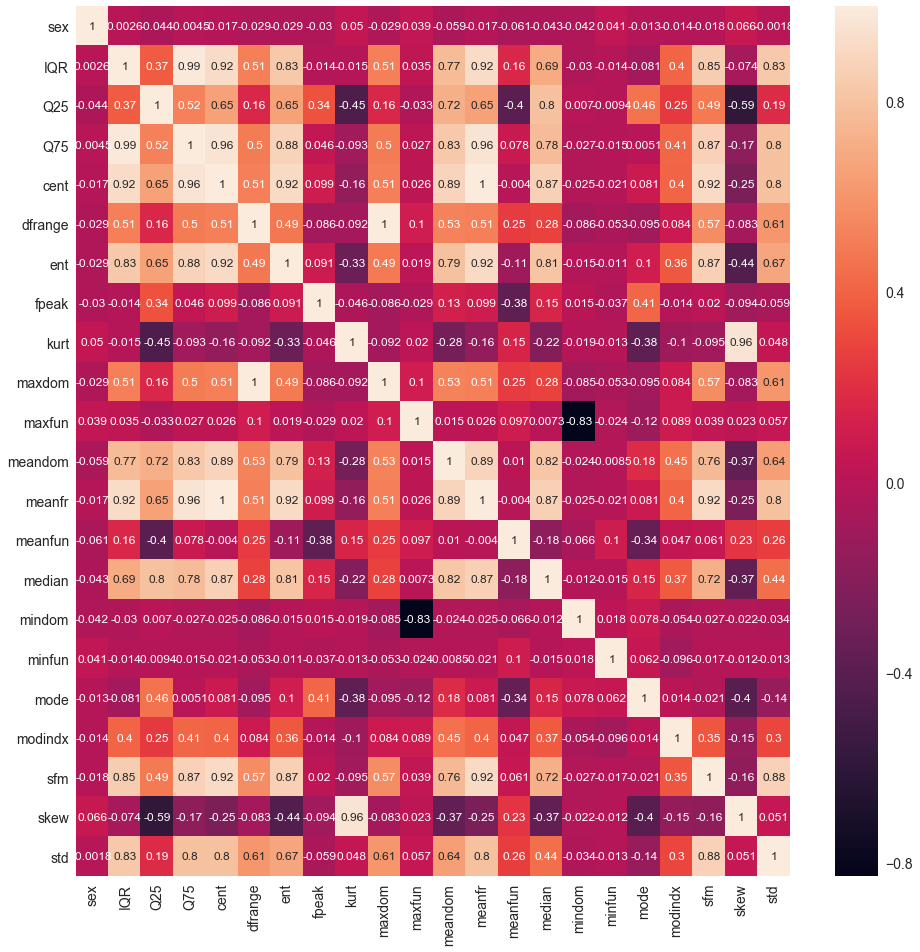

In [22]:
see_correlations(X_train, y_train)

##### We see that  there are 4-5 most significant features. also we see big correlations between some statistics of Fast Fourier Transfrom (like spectral flatness-frequency centroid : 0.91), so the guess is to reduce all the features except first 5, may be it will affect results in a good way and simplify future models

In [23]:
X_reduce = X.drop(['meanfr', 'median', 'Q75',
       'sfm', 'cent', 'minfun', 'maxfun',
       'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx', 'IQR', 'Q25', 'ent', 'std'],
      axis = 1)

##### MLP NN on reduced dataset

In [24]:
state = np.random.get_state()
np.random.seed(42)
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Nadam
from sklearn.model_selection import StratifiedKFold

In [25]:
y = to_categorical(y, 2)

In [26]:
def neural_network():
    x_input = Input(shape=(5,))

    hidden1 = Dense(units=64, activation='tanh')(x_input)
    hidden1 = Dropout(0.25)(hidden1)
    hidden2 = Dense(units=256, activation='tanh')(hidden1)
    hidden2 = Dropout(0.25)(hidden2)
    hidden3 = Dense(units=256, activation='tanh')(hidden2)
    hidden3 = Dropout(0.25)(hidden3)
    hidden4 = Dense(units=64, activation='tanh')(hidden3)

    y_output = Dense(units=2, activation='softmax')(hidden4)

    model = Model(inputs=x_input, outputs=y_output)
    model.compile(loss='kullback_leibler_divergence', optimizer=Nadam(lr=1e-3), metrics=['accuracy'])
    
    return model

In [27]:
kFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
epochs = 150
batch_size = 32

scores_red = []
for train, test in kFold.split(X_reduce, y[:, 0]):
    model = neural_network()
    model.fit(X_reduce.values[train], y[train], 
              validation_data=(X_reduce.values[test], y[test]), 
              epochs=epochs, batch_size=batch_size, verbose=0)
    score = model.evaluate(X_reduce.values[test], y[test], verbose=0)
    print('Accuracy: {:.3f}'.format(score[1]))
    scores_red.append(score[1])
print('Neural network: {:.3f}±{:.3f}'.format(np.mean(scores_red), np.std(scores_red)))
np.random.set_state(state)

Accuracy: 0.825
Accuracy: 0.812
Accuracy: 0.841
Accuracy: 0.785
Accuracy: 0.879
Neural network: 0.829±0.031


##### Models on reduced dataset

In [28]:
y = shuffled.sex

In [29]:
boost_reduce = GradientBoostingClassifier(random_state = 42)
cross_val_model(boost_reduce, X_reduce, y, 0)

GradientBoostingClassifier: 0.858±0.016


In [30]:
forest_reduce = RandomForestClassifier(random_state = 42)
cross_val_model(forest_reduce, X_reduce, y, 0)

RandomForestClassifier: 0.819±0.014


In [31]:
svm_reduce = SVC(random_state = 42, probability=True)
cross_val_model(svm, X_reduce, y, 0)

SVC: 0.809±0.018


In [32]:
X_train = X_train.drop(['meanfr', 'median', 'Q75',
       'sfm', 'cent', 'minfun', 'maxfun',
       'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx', 'IQR', 'Q25', 'ent', 'std'],
      axis = 1)

X_test = X_test.drop(['meanfr', 'median', 'Q75',
       'sfm', 'cent', 'minfun', 'maxfun',
       'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx', 'IQR', 'Q25', 'ent', 'std'],
      axis = 1)

In [33]:
#Stacked model: forest+svc+boosting --> boosting --> output
forest_reduce.fit(X_train, y_train)
svm_reduce.fit(X_train, y_train)
boost_reduce.fit(X_train, y_train)
combo = pd.DataFrame({'forest': forest_reduce.predict_proba(X_test)[:, 1], 
                      'svm': svm_reduce.predict_proba(X_test)[:, 1], 
                      'boost': boost_reduce.predict_proba(X_test)[:, 1]})
cross_val_model(boost_reduce, combo, y_test, 0)

GradientBoostingClassifier: 0.820±0.019


##### As we see, results with feature reduction is quiet the same, somewhere it gives a bit higher score, in other place a bit lower, but still it is same score-level with least amount of features. Simple models are more preferable (AIC criterion for example), so we decided drop all features except first 5.

##### Now, we are trying to find separability and vizualize the data

In [34]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_reduce)

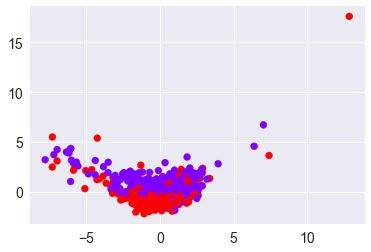

In [35]:
fig, ax = plt.subplots(1)

ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y.values, cmap= 'rainbow')

In [36]:
from sklearn.decomposition import KernelPCA

kernel = KernelPCA(kernel='rbf', gamma=0.1, n_components=2, random_state=42)
X_kernel = kernel.fit_transform(X_reduce)

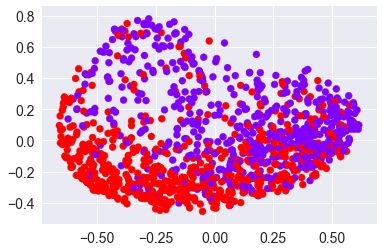

In [37]:
fig, ax = plt.subplots(1)

ax.scatter(X_kernel[:, 0], X_kernel[:, 1], c=y.values, cmap= 'rainbow')

In [38]:
from sklearn.manifold import Isomap

isomap = Isomap(n_neighbors=30, n_components=2, n_jobs=-1)
X_iso = isomap.fit_transform(X_reduce)

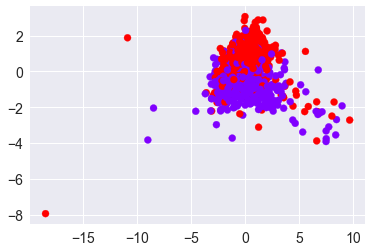

In [39]:
fig, ax = plt.subplots(1)

ax.scatter(X_iso[:, 0], X_iso[:, 1], c=y.values, cmap= 'rainbow')

##### We see nothing successful and helpful with PCA.

##### Before tuning parameters, let us look at the fact of splitting male and female by voice with respect to fundamental frequency (it stated that fundamental frequency is lower for male). Moreover we see that it is in the 2 place in feature importance 

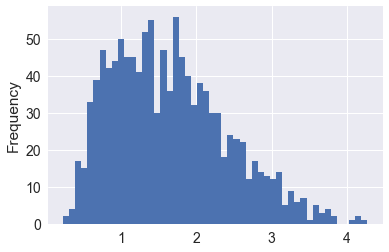

In [40]:
fig, ax = plt.subplots(1)
ax = full_data.meanfun.plot.hist(bins=50)

fig.savefig('histnn.png')

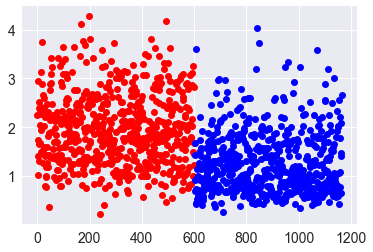

In [41]:
fig, ax = plt.subplots(1)

ax.plot(np.arange(np.sum(full_data.sex == 1)), full_data.meanfun[full_data.sex == 1], 'ro')
ax.plot(np.arange(np.sum(full_data.sex == 1), np.size(full_data.sex)), full_data.meanfun[full_data.sex == 0], 'bo')

##### The separable line should be horizontal, but we actually do not see any good separability

##### Tuning parameters: Random forest, Xgboost, SVM, Stacked model

##### Random forest

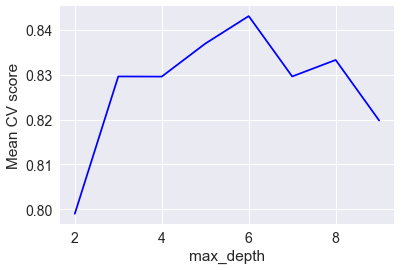

In [42]:
forest = RandomForestClassifier(random_state = 42)
prange=np.arange(2,10,1)
train_scores, cv_scores = validation_curve(forest, X_train, y_train ,param_name='max_depth',
                                              param_range=prange, scoring = 'accuracy')

plt.xlabel('max_depth')
plt.ylabel('Mean CV score')
plt.plot(prange, np.mean(cv_scores, axis=1), label="Cross-validation score",color="b")

In [43]:
forest_tune = RandomForestClassifier(random_state = 42, max_depth = prange[np.argmax(np.mean(cv_scores, axis=1))])
parameters_rf = {'n_estimators': np.arange(5, 20, 1),  
                'min_samples_leaf': np.arange(1, 10, 1),
                'min_samples_split':np.arange(3, 5, 1)}
forest_tune = GridSearchCV(forest_tune, param_grid = parameters_rf, scoring='accuracy', verbose = 2, n_jobs = 4, cv = 5)
forest_tune.fit(X_train, y_train)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=5 .........
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=5 .........
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=5 .........
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=5 .........
[CV]  min_samples_leaf=1, min_samples_split=3, n_estimators=5, total=   0.0s
[CV]  min_samples_leaf=1, min_samples_split=3, n_estimators=5, total=   0.0s
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=5 .........
[CV]  min_samples_leaf=1, min_samples_split=3, n_estimators=5, total=   0.0s
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=6 .........
[CV]  min_samples_leaf=1, min_samples_split=3, n_estimators=5, total=   0.0s
[CV]  min_samples_leaf=1, min_samples_split=3, n_estimators=5, total=   0.0s
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=6 .........
[CV] min_samples_leaf=1, min_samples_split=3, n_estima

[CV]  min_samples_leaf=1, min_samples_split=3, n_estimators=15, total=   0.1s
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=15 ........
[CV]  min_samples_leaf=1, min_samples_split=3, n_estimators=14, total=   0.0s
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=18 ........
[CV]  min_samples_leaf=1, min_samples_split=3, n_estimators=16, total=   0.1s
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=16 ........
[CV]  min_samples_leaf=1, min_samples_split=3, n_estimators=15, total=   0.0s
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=16 ........
[CV]  min_samples_leaf=1, min_samples_split=3, n_estimators=17, total=   0.1s
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=17 ........
[CV]  min_samples_leaf=1, min_samples_split=3, n_estimators=18, total=   0.1s
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=18 ........
[CV]  min_samples_leaf=1, min_samples_split=3, n_estimators=16, total=   0.1s
[CV] min_samples_leaf=1, min

[CV] min_samples_leaf=1, min_samples_split=4, n_estimators=10 ........
[CV]  min_samples_leaf=1, min_samples_split=4, n_estimators=11, total=   0.0s
[CV] min_samples_leaf=1, min_samples_split=4, n_estimators=11 ........
[CV]  min_samples_leaf=1, min_samples_split=4, n_estimators=13, total=   0.1s
[CV] min_samples_leaf=1, min_samples_split=4, n_estimators=13 ........
[CV]  min_samples_leaf=1, min_samples_split=4, n_estimators=12, total=   0.0s
[CV]  min_samples_leaf=1, min_samples_split=4, n_estimators=10, total=   0.0s
[CV] min_samples_leaf=1, min_samples_split=4, n_estimators=12 ........
[CV] min_samples_leaf=1, min_samples_split=4, n_estimators=14 ........
[CV]  min_samples_leaf=1, min_samples_split=4, n_estimators=11, total=   0.0s
[CV] min_samples_leaf=1, min_samples_split=4, n_estimators=11 ........
[CV]  min_samples_leaf=1, min_samples_split=4, n_estimators=13, total=   0.1s
[CV] min_samples_leaf=1, min_samples_split=4, n_estimators=13 ........
[CV]  min_samples_leaf=1, min_sampl

[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=5 .........
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=8 .........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=7, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=10 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=5, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=11 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=9, total=   0.1s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=9 .........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=8, total=   0.1s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=8 .........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=10, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=10 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=11, total=   0.0s
[CV] min_samples_leaf=2, min_samples_sp

[Parallel(n_jobs=4)]: Done 158 tasks      | elapsed:    2.5s


[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=9, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=10 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=12, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=12 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=11, total=   0.0s
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=12, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=11 ........
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=13 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=10, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=13 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=12, total=   0.1s
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=11, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=12 ........
[CV] min_samples_leaf=2, min_

[CV] min_samples_leaf=2, min_samples_split=4, n_estimators=8 .........
[CV]  min_samples_leaf=2, min_samples_split=4, n_estimators=7, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=4, n_estimators=8 .........
[CV]  min_samples_leaf=2, min_samples_split=4, n_estimators=8, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=4, n_estimators=8 .........
[CV]  min_samples_leaf=2, min_samples_split=4, n_estimators=9, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=4, n_estimators=9 .........
[CV]  min_samples_leaf=2, min_samples_split=4, n_estimators=8, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=4, n_estimators=8 .........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=19, total=   0.1s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=19 ........
[CV]  min_samples_leaf=2, min_samples_split=4, n_estimators=8, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=4, n_estimators=9 .........
[CV]  min_samples_leaf=2, min_samples_sp

[CV]  min_samples_leaf=3, min_samples_split=3, n_estimators=5, total=   0.0s
[CV] min_samples_leaf=3, min_samples_split=3, n_estimators=5 .........
[CV]  min_samples_leaf=2, min_samples_split=4, n_estimators=17, total=   0.1s
[CV] min_samples_leaf=2, min_samples_split=4, n_estimators=17 ........
[CV]  min_samples_leaf=3, min_samples_split=3, n_estimators=5, total=   0.0s
[CV] min_samples_leaf=3, min_samples_split=3, n_estimators=5 .........
[CV]  min_samples_leaf=2, min_samples_split=4, n_estimators=18, total=   0.1s
[CV] min_samples_leaf=2, min_samples_split=4, n_estimators=18 ........
[CV]  min_samples_leaf=3, min_samples_split=3, n_estimators=5, total=   0.0s
[CV] min_samples_leaf=3, min_samples_split=3, n_estimators=6 .........
[CV]  min_samples_leaf=2, min_samples_split=4, n_estimators=19, total=   0.1s
[CV] min_samples_leaf=2, min_samples_split=4, n_estimators=19 ........
[CV]  min_samples_leaf=3, min_samples_split=3, n_estimators=6, total=   0.0s
[CV] min_samples_leaf=3, min_sam

[CV] min_samples_leaf=3, min_samples_split=3, n_estimators=15 ........
[CV]  min_samples_leaf=3, min_samples_split=3, n_estimators=16, total=   0.1s
[CV] min_samples_leaf=3, min_samples_split=3, n_estimators=16 ........
[CV]  min_samples_leaf=3, min_samples_split=3, n_estimators=13, total=   0.0s
[CV] min_samples_leaf=3, min_samples_split=3, n_estimators=17 ........
[CV]  min_samples_leaf=3, min_samples_split=3, n_estimators=15, total=   0.0s
[CV] min_samples_leaf=3, min_samples_split=3, n_estimators=15 ........
[CV]  min_samples_leaf=3, min_samples_split=3, n_estimators=14, total=   0.1s
[CV] min_samples_leaf=3, min_samples_split=3, n_estimators=14 ........
[CV]  min_samples_leaf=3, min_samples_split=3, n_estimators=16, total=   0.1s
[CV] min_samples_leaf=3, min_samples_split=3, n_estimators=16 ........
[CV]  min_samples_leaf=3, min_samples_split=3, n_estimators=14, total=   0.0s
[CV] min_samples_leaf=3, min_samples_split=3, n_estimators=14 ........
[CV]  min_samples_leaf=3, min_sampl

[CV]  min_samples_leaf=3, min_samples_split=4, n_estimators=11, total=   0.1s
[CV] min_samples_leaf=3, min_samples_split=4, n_estimators=11 ........
[CV]  min_samples_leaf=3, min_samples_split=4, n_estimators=12, total=   0.0s
[CV] min_samples_leaf=3, min_samples_split=4, n_estimators=12 ........
[CV]  min_samples_leaf=3, min_samples_split=4, n_estimators=10, total=   0.0s
[CV] min_samples_leaf=3, min_samples_split=4, n_estimators=10 ........
[CV]  min_samples_leaf=3, min_samples_split=4, n_estimators=11, total=   0.0s
[CV] min_samples_leaf=3, min_samples_split=4, n_estimators=11 ........
[CV]  min_samples_leaf=3, min_samples_split=4, n_estimators=13, total=   0.1s
[CV] min_samples_leaf=3, min_samples_split=4, n_estimators=13 ........
[CV]  min_samples_leaf=3, min_samples_split=4, n_estimators=12, total=   0.1s
[CV] min_samples_leaf=3, min_samples_split=4, n_estimators=12 ........
[CV]  min_samples_leaf=3, min_samples_split=4, n_estimators=10, total=   0.0s
[CV] min_samples_leaf=3, min

[CV] min_samples_leaf=4, min_samples_split=3, n_estimators=9 .........
[CV]  min_samples_leaf=4, min_samples_split=3, n_estimators=7, total=   0.0s
[CV]  min_samples_leaf=4, min_samples_split=3, n_estimators=5, total=   0.0s
[CV] min_samples_leaf=4, min_samples_split=3, n_estimators=5 .........
[CV] min_samples_leaf=4, min_samples_split=3, n_estimators=8 .........
[CV]  min_samples_leaf=4, min_samples_split=3, n_estimators=7, total=   0.0s
[CV] min_samples_leaf=4, min_samples_split=3, n_estimators=7 .........
[CV]  min_samples_leaf=4, min_samples_split=3, n_estimators=5, total=   0.0s
[CV]  min_samples_leaf=4, min_samples_split=3, n_estimators=9, total=   0.0s
[CV] min_samples_leaf=4, min_samples_split=3, n_estimators=9 .........
[CV] min_samples_leaf=4, min_samples_split=3, n_estimators=10 ........
[CV]  min_samples_leaf=4, min_samples_split=3, n_estimators=8, total=   0.0s
[CV]  min_samples_leaf=4, min_samples_split=3, n_estimators=7, total=   0.0s
[CV] min_samples_leaf=4, min_sample

[CV]  min_samples_leaf=4, min_samples_split=3, n_estimators=17, total=   0.1s
[CV] min_samples_leaf=4, min_samples_split=3, n_estimators=18 ........
[CV]  min_samples_leaf=4, min_samples_split=3, n_estimators=19, total=   0.1s
[CV] min_samples_leaf=4, min_samples_split=4, n_estimators=5 .........
[CV]  min_samples_leaf=4, min_samples_split=3, n_estimators=17, total=   0.1s
[CV] min_samples_leaf=4, min_samples_split=4, n_estimators=6 .........
[CV]  min_samples_leaf=4, min_samples_split=4, n_estimators=5, total=   0.0s
[CV] min_samples_leaf=4, min_samples_split=4, n_estimators=5 .........
[CV]  min_samples_leaf=4, min_samples_split=4, n_estimators=6, total=   0.0s
[CV] min_samples_leaf=4, min_samples_split=4, n_estimators=6 .........
[CV]  min_samples_leaf=4, min_samples_split=4, n_estimators=5, total=   0.0s
[CV] min_samples_leaf=4, min_samples_split=4, n_estimators=5 .........
[CV]  min_samples_leaf=4, min_samples_split=3, n_estimators=19, total=   0.1s
[CV] min_samples_leaf=4, min_sa

[CV] min_samples_leaf=4, min_samples_split=4, n_estimators=16 ........
[CV]  min_samples_leaf=4, min_samples_split=4, n_estimators=14, total=   0.0s
[CV] min_samples_leaf=4, min_samples_split=4, n_estimators=15 ........
[CV]  min_samples_leaf=4, min_samples_split=4, n_estimators=15, total=   0.1s
[CV] min_samples_leaf=4, min_samples_split=4, n_estimators=15 ........
[CV]  min_samples_leaf=4, min_samples_split=4, n_estimators=13, total=   0.1s
[CV] min_samples_leaf=4, min_samples_split=4, n_estimators=14 ........
[CV]  min_samples_leaf=4, min_samples_split=4, n_estimators=15, total=   0.0s
[CV] min_samples_leaf=4, min_samples_split=4, n_estimators=15 ........
[CV]  min_samples_leaf=4, min_samples_split=4, n_estimators=14, total=   0.1s
[CV]  min_samples_leaf=4, min_samples_split=4, n_estimators=15, total=   0.1s
[CV] min_samples_leaf=4, min_samples_split=4, n_estimators=14 ........
[CV] min_samples_leaf=4, min_samples_split=4, n_estimators=16 ........
[CV]  min_samples_leaf=4, min_sampl

[CV]  min_samples_leaf=5, min_samples_split=3, n_estimators=9, total=   0.0s
[CV] min_samples_leaf=5, min_samples_split=3, n_estimators=9 .........
[CV]  min_samples_leaf=5, min_samples_split=3, n_estimators=10, total=   0.1s
[CV] min_samples_leaf=5, min_samples_split=3, n_estimators=10 ........
[CV]  min_samples_leaf=5, min_samples_split=3, n_estimators=8, total=   0.0s
[CV] min_samples_leaf=5, min_samples_split=3, n_estimators=12 ........
[CV]  min_samples_leaf=5, min_samples_split=3, n_estimators=9, total=   0.0s
[CV] min_samples_leaf=5, min_samples_split=3, n_estimators=10 ........
[CV]  min_samples_leaf=5, min_samples_split=3, n_estimators=10, total=   0.0s
[CV] min_samples_leaf=5, min_samples_split=3, n_estimators=11 ........
[CV]  min_samples_leaf=5, min_samples_split=3, n_estimators=11, total=   0.1s
[CV] min_samples_leaf=5, min_samples_split=3, n_estimators=12 ........
[CV]  min_samples_leaf=5, min_samples_split=3, n_estimators=12, total=   0.0s
[CV] min_samples_leaf=5, min_sa

[CV] min_samples_leaf=5, min_samples_split=4, n_estimators=7 .........
[CV]  min_samples_leaf=5, min_samples_split=4, n_estimators=7, total=   0.0s
[CV] min_samples_leaf=5, min_samples_split=4, n_estimators=7 .........
[CV]  min_samples_leaf=5, min_samples_split=3, n_estimators=18, total=   0.1s
[CV] min_samples_leaf=5, min_samples_split=4, n_estimators=8 .........
[CV]  min_samples_leaf=5, min_samples_split=4, n_estimators=7, total=   0.0s
[CV] min_samples_leaf=5, min_samples_split=4, n_estimators=7 .........
[CV]  min_samples_leaf=5, min_samples_split=3, n_estimators=19, total=   0.1s
[CV] min_samples_leaf=5, min_samples_split=3, n_estimators=19 ........
[CV]  min_samples_leaf=5, min_samples_split=4, n_estimators=7, total=   0.0s
[CV] min_samples_leaf=5, min_samples_split=4, n_estimators=9 .........
[CV]  min_samples_leaf=5, min_samples_split=4, n_estimators=8, total=   0.1s
[CV] min_samples_leaf=5, min_samples_split=4, n_estimators=8 .........
[CV]  min_samples_leaf=5, min_samples_s

[CV]  min_samples_leaf=5, min_samples_split=4, n_estimators=19, total=   0.1s
[CV] min_samples_leaf=5, min_samples_split=4, n_estimators=19 ........
[CV]  min_samples_leaf=5, min_samples_split=4, n_estimators=18, total=   0.1s
[CV] min_samples_leaf=5, min_samples_split=4, n_estimators=18 ........
[CV]  min_samples_leaf=5, min_samples_split=4, n_estimators=17, total=   0.1s
[CV] min_samples_leaf=5, min_samples_split=4, n_estimators=17 ........
[CV]  min_samples_leaf=5, min_samples_split=4, n_estimators=16, total=   0.1s
[CV] min_samples_leaf=6, min_samples_split=3, n_estimators=5 .........
[CV]  min_samples_leaf=6, min_samples_split=3, n_estimators=5, total=   0.0s
[CV] min_samples_leaf=6, min_samples_split=3, n_estimators=5 .........
[CV]  min_samples_leaf=5, min_samples_split=4, n_estimators=19, total=   0.1s
[CV] min_samples_leaf=5, min_samples_split=4, n_estimators=19 ........
[CV]  min_samples_leaf=5, min_samples_split=4, n_estimators=18, total=   0.1s
[CV] min_samples_leaf=5, min_

[CV]  min_samples_leaf=6, min_samples_split=3, n_estimators=14, total=   0.1s
[CV] min_samples_leaf=6, min_samples_split=3, n_estimators=15 ........
[CV] min_samples_leaf=6, min_samples_split=3, n_estimators=14 ........
[CV]  min_samples_leaf=6, min_samples_split=3, n_estimators=12, total=   0.1s
[CV] min_samples_leaf=6, min_samples_split=3, n_estimators=16 ........
[CV]  min_samples_leaf=6, min_samples_split=3, n_estimators=14, total=   0.0s
[CV] min_samples_leaf=6, min_samples_split=3, n_estimators=14 ........
[CV]  min_samples_leaf=6, min_samples_split=3, n_estimators=13, total=   0.1s
[CV] min_samples_leaf=6, min_samples_split=3, n_estimators=13 ........
[CV]  min_samples_leaf=6, min_samples_split=3, n_estimators=15, total=   0.1s
[CV] min_samples_leaf=6, min_samples_split=3, n_estimators=15 ........
[CV]  min_samples_leaf=6, min_samples_split=3, n_estimators=13, total=   0.0s
[CV]  min_samples_leaf=6, min_samples_split=3, n_estimators=16, total=   0.1s
[CV] min_samples_leaf=6, min

[CV]  min_samples_leaf=6, min_samples_split=4, n_estimators=8, total=   0.0s
[CV] min_samples_leaf=6, min_samples_split=4, n_estimators=12 ........
[CV]  min_samples_leaf=6, min_samples_split=4, n_estimators=10, total=   0.1s
[CV] min_samples_leaf=6, min_samples_split=4, n_estimators=11 ........
[CV]  min_samples_leaf=6, min_samples_split=4, n_estimators=10, total=   0.1s
[CV] min_samples_leaf=6, min_samples_split=4, n_estimators=10 ........
[CV]  min_samples_leaf=6, min_samples_split=4, n_estimators=9, total=   0.0s
[CV] min_samples_leaf=6, min_samples_split=4, n_estimators=13 ........
[CV]  min_samples_leaf=6, min_samples_split=4, n_estimators=12, total=   0.1s
[CV] min_samples_leaf=6, min_samples_split=4, n_estimators=12 ........
[CV]  min_samples_leaf=6, min_samples_split=4, n_estimators=11, total=   0.1s
[CV] min_samples_leaf=6, min_samples_split=4, n_estimators=11 ........
[CV]  min_samples_leaf=6, min_samples_split=4, n_estimators=10, total=   0.1s
[CV] min_samples_leaf=6, min_s

[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=6 .........
[CV]  min_samples_leaf=7, min_samples_split=3, n_estimators=6, total=   0.0s
[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=7 .........
[CV]  min_samples_leaf=7, min_samples_split=3, n_estimators=6, total=   0.0s
[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=7 .........


[Parallel(n_jobs=4)]: Done 884 tasks      | elapsed:   13.7s


[CV]  min_samples_leaf=7, min_samples_split=3, n_estimators=7, total=   0.0s
[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=7 .........
[CV]  min_samples_leaf=6, min_samples_split=4, n_estimators=19, total=   0.1s
[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=9 .........
[CV]  min_samples_leaf=7, min_samples_split=3, n_estimators=7, total=   0.0s
[CV]  min_samples_leaf=6, min_samples_split=4, n_estimators=19, total=   0.1s
[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=5 .........
[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=8 .........
[CV]  min_samples_leaf=7, min_samples_split=3, n_estimators=7, total=   0.0s
[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=7 .........
[CV]  min_samples_leaf=7, min_samples_split=3, n_estimators=5, total=   0.0s
[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=5 .........
[CV]  min_samples_leaf=7, min_samples_split=3, n_estimators=9, total=   0.1s
[CV] min_samples_leaf=7, min_samp

[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=17 ........
[CV]  min_samples_leaf=7, min_samples_split=3, n_estimators=16, total=   0.1s
[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=19 ........
[CV]  min_samples_leaf=7, min_samples_split=3, n_estimators=17, total=   0.1s
[CV]  min_samples_leaf=7, min_samples_split=3, n_estimators=18, total=   0.1s
[CV]  min_samples_leaf=7, min_samples_split=3, n_estimators=17, total=   0.0s
[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=18 ........
[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=19 ........
[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=17 ........
[CV]  min_samples_leaf=7, min_samples_split=3, n_estimators=19, total=   0.1s
[CV] min_samples_leaf=7, min_samples_split=4, n_estimators=5 .........
[CV]  min_samples_leaf=7, min_samples_split=3, n_estimators=17, total=   0.1s
[CV]  min_samples_leaf=7, min_samples_split=3, n_estimators=18, total=   0.1s
[CV] min_samples_leaf=7, min

[CV]  min_samples_leaf=7, min_samples_split=4, n_estimators=13, total=   0.1s
[CV] min_samples_leaf=7, min_samples_split=4, n_estimators=13 ........
[CV]  min_samples_leaf=7, min_samples_split=4, n_estimators=14, total=   0.1s
[CV] min_samples_leaf=7, min_samples_split=4, n_estimators=14 ........
[CV]  min_samples_leaf=7, min_samples_split=4, n_estimators=12, total=   0.1s
[CV] min_samples_leaf=7, min_samples_split=4, n_estimators=13 ........
[CV]  min_samples_leaf=7, min_samples_split=4, n_estimators=13, total=   0.0s
[CV] min_samples_leaf=7, min_samples_split=4, n_estimators=14 ........
[CV]  min_samples_leaf=7, min_samples_split=4, n_estimators=15, total=   0.1s
[CV] min_samples_leaf=7, min_samples_split=4, n_estimators=15 ........
[CV]  min_samples_leaf=7, min_samples_split=4, n_estimators=14, total=   0.1s
[CV] min_samples_leaf=7, min_samples_split=4, n_estimators=15 ........
[CV]  min_samples_leaf=7, min_samples_split=4, n_estimators=13, total=   0.1s
[CV] min_samples_leaf=7, min

[CV]  min_samples_leaf=8, min_samples_split=3, n_estimators=9, total=   0.0s
[CV] min_samples_leaf=8, min_samples_split=3, n_estimators=11 ........
[CV] min_samples_leaf=8, min_samples_split=3, n_estimators=9 .........
[CV]  min_samples_leaf=8, min_samples_split=3, n_estimators=8, total=   0.0s
[CV] min_samples_leaf=8, min_samples_split=3, n_estimators=8 .........
[CV]  min_samples_leaf=8, min_samples_split=3, n_estimators=10, total=   0.1s
[CV] min_samples_leaf=8, min_samples_split=3, n_estimators=10 ........
[CV]  min_samples_leaf=8, min_samples_split=3, n_estimators=9, total=   0.0s
[CV] min_samples_leaf=8, min_samples_split=3, n_estimators=9 .........
[CV]  min_samples_leaf=8, min_samples_split=3, n_estimators=11, total=   0.1s
[CV]  min_samples_leaf=8, min_samples_split=3, n_estimators=8, total=   0.1s
[CV] min_samples_leaf=8, min_samples_split=3, n_estimators=12 ........
[CV] min_samples_leaf=8, min_samples_split=3, n_estimators=11 ........
[CV]  min_samples_leaf=8, min_samples_s

[CV]  min_samples_leaf=8, min_samples_split=4, n_estimators=7, total=   0.0s
[CV] min_samples_leaf=8, min_samples_split=4, n_estimators=7 .........
[CV]  min_samples_leaf=8, min_samples_split=3, n_estimators=19, total=   0.1s
[CV] min_samples_leaf=8, min_samples_split=3, n_estimators=19 ........
[CV]  min_samples_leaf=8, min_samples_split=4, n_estimators=6, total=   0.0s
[CV]  min_samples_leaf=8, min_samples_split=4, n_estimators=7, total=   0.0s
[CV] min_samples_leaf=8, min_samples_split=4, n_estimators=6 .........
[CV] min_samples_leaf=8, min_samples_split=4, n_estimators=7 .........
[CV]  min_samples_leaf=8, min_samples_split=4, n_estimators=6, total=   0.0s
[CV] min_samples_leaf=8, min_samples_split=4, n_estimators=6 .........
[CV]  min_samples_leaf=8, min_samples_split=3, n_estimators=18, total=   0.1s
[CV] min_samples_leaf=8, min_samples_split=4, n_estimators=8 .........
[CV]  min_samples_leaf=8, min_samples_split=4, n_estimators=7, total=   0.0s
[CV] min_samples_leaf=8, min_samp

[CV] min_samples_leaf=8, min_samples_split=4, n_estimators=18 ........
[CV]  min_samples_leaf=8, min_samples_split=4, n_estimators=16, total=   0.1s
[CV] min_samples_leaf=8, min_samples_split=4, n_estimators=16 ........
[CV]  min_samples_leaf=8, min_samples_split=4, n_estimators=15, total=   0.1s
[CV] min_samples_leaf=8, min_samples_split=4, n_estimators=19 ........
[CV]  min_samples_leaf=8, min_samples_split=4, n_estimators=18, total=   0.1s
[CV]  min_samples_leaf=8, min_samples_split=4, n_estimators=17, total=   0.1s
[CV] min_samples_leaf=8, min_samples_split=4, n_estimators=18 ........
[CV] min_samples_leaf=8, min_samples_split=4, n_estimators=17 ........
[CV]  min_samples_leaf=8, min_samples_split=4, n_estimators=16, total=   0.1s
[CV] min_samples_leaf=8, min_samples_split=4, n_estimators=16 ........
[CV]  min_samples_leaf=8, min_samples_split=4, n_estimators=19, total=   0.1s
[CV] min_samples_leaf=8, min_samples_split=4, n_estimators=19 ........
[CV]  min_samples_leaf=8, min_sampl

[CV]  min_samples_leaf=9, min_samples_split=3, n_estimators=13, total=   0.1s
[CV] min_samples_leaf=9, min_samples_split=3, n_estimators=14 ........
[CV]  min_samples_leaf=9, min_samples_split=3, n_estimators=13, total=   0.1s
[CV] min_samples_leaf=9, min_samples_split=3, n_estimators=13 ........
[CV]  min_samples_leaf=9, min_samples_split=3, n_estimators=12, total=   0.1s
[CV] min_samples_leaf=9, min_samples_split=3, n_estimators=16 ........
[CV]  min_samples_leaf=9, min_samples_split=3, n_estimators=14, total=   0.1s
[CV] min_samples_leaf=9, min_samples_split=3, n_estimators=14 ........
[CV]  min_samples_leaf=9, min_samples_split=3, n_estimators=15, total=   0.1s
[CV] min_samples_leaf=9, min_samples_split=3, n_estimators=15 ........
[CV]  min_samples_leaf=9, min_samples_split=3, n_estimators=13, total=   0.1s
[CV] min_samples_leaf=9, min_samples_split=3, n_estimators=13 ........
[CV]  min_samples_leaf=9, min_samples_split=3, n_estimators=16, total=   0.1s
[CV] min_samples_leaf=9, min

[CV] min_samples_leaf=9, min_samples_split=4, n_estimators=10 ........
[CV]  min_samples_leaf=9, min_samples_split=4, n_estimators=9, total=   0.0s
[CV] min_samples_leaf=9, min_samples_split=4, n_estimators=9 .........
[CV]  min_samples_leaf=9, min_samples_split=3, n_estimators=19, total=   0.1s
[CV] min_samples_leaf=9, min_samples_split=4, n_estimators=10 ........
[CV]  min_samples_leaf=9, min_samples_split=4, n_estimators=8, total=   0.0s
[CV] min_samples_leaf=9, min_samples_split=4, n_estimators=8 .........
[CV]  min_samples_leaf=9, min_samples_split=4, n_estimators=9, total=   0.0s
[CV] min_samples_leaf=9, min_samples_split=4, n_estimators=9 .........
[CV]  min_samples_leaf=9, min_samples_split=4, n_estimators=8, total=   0.0s
[CV]  min_samples_leaf=9, min_samples_split=4, n_estimators=10, total=   0.1s
[CV] min_samples_leaf=9, min_samples_split=4, n_estimators=10 ........
[CV]  min_samples_leaf=9, min_samples_split=4, n_estimators=10, total=   0.0s
[CV] min_samples_leaf=9, min_sam

[Parallel(n_jobs=4)]: Done 1350 out of 1350 | elapsed:   21.0s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'n_estimators': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]), 'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]), 'min_samples_split': array([3, 4])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [44]:
forest_tune.best_estimator_.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 13,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [45]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_predict_forest_tune = forest_tune.predict(X_test)
print('accuracy', accuracy_score(y_test, y_predict_forest_tune))
conf_mat = pd.DataFrame(confusion_matrix(y_predict_forest_tune, y_test))
conf_mat

accuracy 0.848571428571


,0,1
0,144,30
1,23,153


##### Xgboost

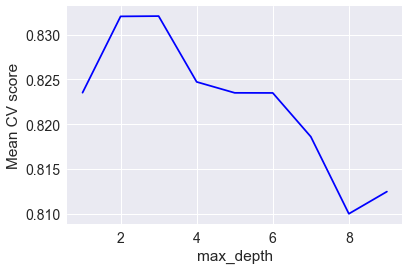

In [46]:
boost = GradientBoostingClassifier(random_state = 42)
prange=np.arange(1,10,1)
train_scores, cv_scores = validation_curve(boost, X_train, y_train ,param_name='max_depth',
                                              param_range=prange, scoring = 'accuracy')

plt.xlabel('max_depth')
plt.ylabel('Mean CV score')
plt.plot(prange, np.mean(cv_scores, axis=1), label="Cross-validation score",color="b")

In [47]:
boost_tune = GradientBoostingClassifier(random_state = 42, max_depth = prange[np.argmax(np.mean(cv_scores, axis=1))])
parameters_b_new = {'learning_rate': np.arange(0.01, 0.13, 0.02), 'n_estimators': np.arange(50,150, 20)}
boosting_tune = GridSearchCV(boost_tune, param_grid = parameters_b_new, scoring='accuracy', verbose = 2, cv = 5)
boosting_tune.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] learning_rate=0.01, n_estimators=50 .............................
[CV] .............. learning_rate=0.01, n_estimators=50, total=   0.0s
[CV] learning_rate=0.01, n_estimators=50 .............................
[CV] .............. learning_rate=0.01, n_estimators=50, total=   0.0s
[CV] learning_rate=0.01, n_estimators=50 .............................
[CV] .............. learning_rate=0.01, n_estimators=50, total=   0.0s
[CV] learning_rate=0.01, n_estimators=50 .............................
[CV] .............. learning_rate=0.01, n_estimators=50, total=   0.0s
[CV] learning_rate=0.01, n_estimators=50 .............................
[CV] .............. learning_rate=0.01, n_estimators=50, total=   0.0s
[CV] learning_rate=0.01, n_estimators=70 .............................
[CV] .............. learning_rate=0.01, n_estimators=70, total=   0.0s
[CV] learning_rate=0.01, n_estimators=70 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .............. learning_rate=0.01, n_estimators=70, total=   0.0s
[CV] learning_rate=0.01, n_estimators=70 .............................
[CV] .............. learning_rate=0.01, n_estimators=70, total=   0.0s
[CV] learning_rate=0.01, n_estimators=70 .............................
[CV] .............. learning_rate=0.01, n_estimators=70, total=   0.0s
[CV] learning_rate=0.01, n_estimators=70 .............................
[CV] .............. learning_rate=0.01, n_estimators=70, total=   0.0s
[CV] learning_rate=0.01, n_estimators=90 .............................
[CV] .............. learning_rate=0.01, n_estimators=90, total=   0.1s
[CV] learning_rate=0.01, n_estimators=90 .............................
[CV] .............. learning_rate=0.01, n_estimators=90, total=   0.1s
[CV] learning_rate=0.01, n_estimators=90 .............................
[CV] .............. learning_rate=0.01, n_estimators=90, total=   0.1s
[CV] learning_rate=0.01, n_estimators=90 .............................
[CV] .

[CV] .............. learning_rate=0.05, n_estimators=90, total=   0.1s
[CV] learning_rate=0.05, n_estimators=110 ............................
[CV] ............. learning_rate=0.05, n_estimators=110, total=   0.1s
[CV] learning_rate=0.05, n_estimators=110 ............................
[CV] ............. learning_rate=0.05, n_estimators=110, total=   0.1s
[CV] learning_rate=0.05, n_estimators=110 ............................
[CV] ............. learning_rate=0.05, n_estimators=110, total=   0.1s
[CV] learning_rate=0.05, n_estimators=110 ............................
[CV] ............. learning_rate=0.05, n_estimators=110, total=   0.1s
[CV] learning_rate=0.05, n_estimators=110 ............................
[CV] ............. learning_rate=0.05, n_estimators=110, total=   0.1s
[CV] learning_rate=0.05, n_estimators=130 ............................
[CV] ............. learning_rate=0.05, n_estimators=130, total=   0.1s
[CV] learning_rate=0.05, n_estimators=130 ............................
[CV] .

[CV] ............. learning_rate=0.09, n_estimators=130, total=   0.1s
[CV] learning_rate=0.09, n_estimators=130 ............................
[CV] ............. learning_rate=0.09, n_estimators=130, total=   0.1s
[CV] learning_rate=0.09, n_estimators=130 ............................
[CV] ............. learning_rate=0.09, n_estimators=130, total=   0.1s
[CV] learning_rate=0.11, n_estimators=50 .............................
[CV] .............. learning_rate=0.11, n_estimators=50, total=   0.0s
[CV] learning_rate=0.11, n_estimators=50 .............................
[CV] .............. learning_rate=0.11, n_estimators=50, total=   0.0s
[CV] learning_rate=0.11, n_estimators=50 .............................
[CV] .............. learning_rate=0.11, n_estimators=50, total=   0.0s
[CV] learning_rate=0.11, n_estimators=50 .............................
[CV] .............. learning_rate=0.11, n_estimators=50, total=   0.0s
[CV] learning_rate=0.11, n_estimators=50 .............................
[CV] .

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    8.5s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': array([ 0.01,  0.03,  0.05,  0.07,  0.09,  0.11]), 'n_estimators': array([ 50,  70,  90, 110, 130])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [48]:
boosting_tune.best_estimator_.get_params()

{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.10999999999999997,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'presort': 'auto',
 'random_state': 42,
 'subsample': 1.0,
 'verbose': 0,
 'warm_start': False}

In [49]:
y_predict_boosting_tune = boosting_tune.predict(X_test)
print('accuracy', accuracy_score(y_test, y_predict_boosting_tune))
conf_mat = pd.DataFrame(confusion_matrix(y_predict_boosting_tune, y_test))
conf_mat

accuracy 0.86


,0,1
0,146,28
1,21,155


##### SVM

In [50]:
svm = SVC(random_state = 42, probability=True)
parameters_s_new = {'C': np.arange(0.1,1.2, 0.1), 'gamma': np.arange(0.1,1, 0.1)}
svm_new = GridSearchCV(svm, param_grid = parameters_s_new, scoring='accuracy', verbose = 0, cv = 3)
svm_new.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1]), 'gamma': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [51]:
y_predict_svm_tune = svm_new.predict(X_test)
print('accuracy', accuracy_score(y_test, y_predict_svm_tune))
conf_mat = pd.DataFrame(confusion_matrix(y_predict_svm_tune, y_test))
conf_mat

accuracy 0.834285714286


,0,1
0,145,36
1,22,147


##### Stacked model

In [52]:
boost = GradientBoostingClassifier(random_state = 42)
boost.fit(X_train, y_train)
combo = pd.DataFrame({'forest': forest_tune.predict_proba(X_test)[:, 1], 
                      'svm': svm_new.predict_proba(X_test)[:, 1], 
                      'boost': boosting_tune.predict_proba(X_test)[:, 1]})
cross_val_model(boost, combo, y_test, 0)

def cross_val_model_new(model, X_reduce, y, verbose=2):
    cv = KFold(n_splits=5)
    scores = cross_val_score(model, X_reduce, y, cv=cv, verbose=verbose, scoring='accuracy')
    return (np.mean(scores))

GradientBoostingClassifier: 0.829±0.041


##### Finally, here is score for this dataset with feature extraction from our approach

In [53]:
print('Choosen metric is accuracy')
print('Neural network from the article: {:.3f}'.format(np.mean(scores), np.std(scores)))
print('Random forest: {:.3f}'.format(accuracy_score(y_test, y_predict_forest_tune)))
print('Xgboost: {:.3f}'.format(accuracy_score(y_test, y_predict_boosting_tune)))
print('SVM: {:.3f}'.format(accuracy_score(y_test, y_predict_svm_tune)))
print('Stacked model: {:.3f}'.format(cross_val_model_new(boost, combo, y_test, 0)))

Choosen metric is accuracy
Neural network from the article: 0.827
Random forest: 0.849
Xgboost: 0.860
SVM: 0.834
Stacked model: 0.829


##### We decided to look at the results without reducing features just in case

In [54]:
X = pd.DataFrame(X, columns = X_shuffled.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

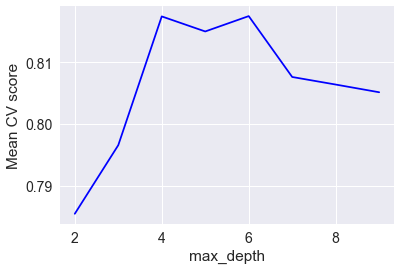

In [55]:
forest = RandomForestClassifier(random_state = 42)
prange=np.arange(2,10,1)
train_scores, cv_scores = validation_curve(forest, X_train, y_train ,param_name='max_depth',
                                              param_range=prange, scoring = 'accuracy')

plt.xlabel('max_depth')
plt.ylabel('Mean CV score')
plt.plot(prange, np.mean(cv_scores, axis=1), label="Cross-validation score",color="b")

In [56]:
forest_tune = RandomForestClassifier(random_state = 42, max_depth = prange[np.argmax(np.mean(cv_scores, axis=1))])
parameters_rf = {'n_estimators': np.arange(5, 20, 1),  
                'min_samples_leaf': np.arange(1, 10, 1),
                'min_samples_split':np.arange(3, 5, 1)}
forest_tune = GridSearchCV(forest_tune, param_grid = parameters_rf, scoring='accuracy', verbose = 2, n_jobs = 4, cv = 5)
forest_tune.fit(X_train, y_train)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=5 .........
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=5 .........
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=5 .........
[CV]  min_samples_leaf=1, min_samples_split=3, n_estimators=5, total=   0.0s
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=5 .........
[CV]  min_samples_leaf=1, min_samples_split=3, n_estimators=5, total=   0.0s
[CV]  min_samples_leaf=1, min_samples_split=3, n_estimators=5, total=   0.0s
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=5 .........
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=6 .........
[CV]  min_samples_leaf=1, min_samples_split=3, n_estimators=5, total=   0.0s
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=6 .........
[CV]  min_samples_leaf=1, min_samples_split=3, n_estimators=5, total=   0.0s
[CV] min_samples_leaf=1, min_samples_split=3, n_estima

[CV]  min_samples_leaf=1, min_samples_split=3, n_estimators=16, total=   0.1s
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=16 ........
[CV]  min_samples_leaf=1, min_samples_split=3, n_estimators=17, total=   0.1s
[CV]  min_samples_leaf=1, min_samples_split=3, n_estimators=14, total=   0.1s
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=17 ........
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=18 ........
[CV]  min_samples_leaf=1, min_samples_split=3, n_estimators=15, total=   0.1s
[CV]  min_samples_leaf=1, min_samples_split=3, n_estimators=16, total=   0.1s
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=16 ........
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=16 ........
[CV]  min_samples_leaf=1, min_samples_split=3, n_estimators=17, total=   0.1s
[CV]  min_samples_leaf=1, min_samples_split=3, n_estimators=16, total=   0.0s
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=17 ........
[CV] min_samples_leaf=1, min

[CV] min_samples_leaf=1, min_samples_split=4, n_estimators=12 ........
[CV]  min_samples_leaf=1, min_samples_split=4, n_estimators=10, total=   0.1s
[CV] min_samples_leaf=1, min_samples_split=4, n_estimators=10 ........
[CV]  min_samples_leaf=1, min_samples_split=4, n_estimators=11, total=   0.0s
[CV] min_samples_leaf=1, min_samples_split=4, n_estimators=11 ........
[CV]  min_samples_leaf=1, min_samples_split=4, n_estimators=13, total=   0.1s
[CV] min_samples_leaf=1, min_samples_split=4, n_estimators=13 ........
[CV]  min_samples_leaf=1, min_samples_split=4, n_estimators=12, total=   0.1s
[CV] min_samples_leaf=1, min_samples_split=4, n_estimators=12 ........
[CV]  min_samples_leaf=1, min_samples_split=4, n_estimators=10, total=   0.0s
[CV] min_samples_leaf=1, min_samples_split=4, n_estimators=14 ........
[CV]  min_samples_leaf=1, min_samples_split=4, n_estimators=11, total=   0.1s
[CV] min_samples_leaf=1, min_samples_split=4, n_estimators=11 ........
[CV]  min_samples_leaf=1, min_sampl

[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=8, total=   0.1s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=8 .........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=7, total=   0.0s
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=5, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=10 ........
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=11 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=9, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=9 .........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=8, total=   0.1s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=8 .........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=10, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=10 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=11, total=   0.0s
[CV]  min_samples_leaf=2, min_sam

[Parallel(n_jobs=4)]: Done 158 tasks      | elapsed:    2.6s


[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=11, total=   0.1s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=12 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=10, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=11 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=12, total=   0.1s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=12 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=10, total=   0.1s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=13 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=12, total=   0.1s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=12 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=11, total=   0.1s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=11 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=13, total=   0.0s
[CV] min_samples_leaf=2, min

[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=19 ........
[CV]  min_samples_leaf=2, min_samples_split=4, n_estimators=7, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=4, n_estimators=7 .........
[CV]  min_samples_leaf=2, min_samples_split=4, n_estimators=8, total=   0.1s
[CV] min_samples_leaf=2, min_samples_split=4, n_estimators=8 .........
[CV]  min_samples_leaf=2, min_samples_split=4, n_estimators=9, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=4, n_estimators=9 .........
[CV]  min_samples_leaf=2, min_samples_split=4, n_estimators=7, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=4, n_estimators=7 .........
[CV]  min_samples_leaf=2, min_samples_split=4, n_estimators=7, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=4, n_estimators=8 .........
[CV]  min_samples_leaf=2, min_samples_split=4, n_estimators=8, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=4, n_estimators=8 .........
[CV]  min_samples_leaf=2, min_samples_spl

[CV]  min_samples_leaf=2, min_samples_split=4, n_estimators=19, total=   0.1s
[CV] min_samples_leaf=2, min_samples_split=4, n_estimators=19 ........
[CV]  min_samples_leaf=2, min_samples_split=4, n_estimators=18, total=   0.1s
[CV] min_samples_leaf=2, min_samples_split=4, n_estimators=18 ........
[CV]  min_samples_leaf=2, min_samples_split=4, n_estimators=17, total=   0.1s
[CV] min_samples_leaf=2, min_samples_split=4, n_estimators=17 ........
[CV]  min_samples_leaf=3, min_samples_split=3, n_estimators=5, total=   0.0s
[CV] min_samples_leaf=3, min_samples_split=3, n_estimators=5 .........
[CV]  min_samples_leaf=3, min_samples_split=3, n_estimators=5, total=   0.0s
[CV] min_samples_leaf=3, min_samples_split=3, n_estimators=5 .........
[CV]  min_samples_leaf=3, min_samples_split=3, n_estimators=5, total=   0.0s
[CV]  min_samples_leaf=2, min_samples_split=4, n_estimators=19, total=   0.1s
[CV] min_samples_leaf=2, min_samples_split=4, n_estimators=19 ........
[CV] min_samples_leaf=3, min_sa

[CV] min_samples_leaf=3, min_samples_split=3, n_estimators=15 ........
[CV]  min_samples_leaf=3, min_samples_split=3, n_estimators=16, total=   0.1s
[CV] min_samples_leaf=3, min_samples_split=3, n_estimators=16 ........
[CV]  min_samples_leaf=3, min_samples_split=3, n_estimators=13, total=   0.1s
[CV] min_samples_leaf=3, min_samples_split=3, n_estimators=13 ........
[CV]  min_samples_leaf=3, min_samples_split=3, n_estimators=14, total=   0.1s
[CV] min_samples_leaf=3, min_samples_split=3, n_estimators=14 ........
[CV]  min_samples_leaf=3, min_samples_split=3, n_estimators=15, total=   0.1s
[CV] min_samples_leaf=3, min_samples_split=3, n_estimators=15 ........
[CV]  min_samples_leaf=3, min_samples_split=3, n_estimators=16, total=   0.1s
[CV]  min_samples_leaf=3, min_samples_split=3, n_estimators=13, total=   0.1s
[CV] min_samples_leaf=3, min_samples_split=3, n_estimators=17 ........
[CV] min_samples_leaf=3, min_samples_split=3, n_estimators=16 ........
[CV]  min_samples_leaf=3, min_sampl

[CV]  min_samples_leaf=3, min_samples_split=4, n_estimators=12, total=   0.1s
[CV] min_samples_leaf=3, min_samples_split=4, n_estimators=12 ........
[CV]  min_samples_leaf=3, min_samples_split=4, n_estimators=11, total=   0.1s
[CV]  min_samples_leaf=3, min_samples_split=4, n_estimators=9, total=   0.0s
[CV] min_samples_leaf=3, min_samples_split=4, n_estimators=11 ........
[CV] min_samples_leaf=3, min_samples_split=4, n_estimators=13 ........
[CV]  min_samples_leaf=3, min_samples_split=4, n_estimators=10, total=   0.0s
[CV] min_samples_leaf=3, min_samples_split=4, n_estimators=10 ........
[CV]  min_samples_leaf=3, min_samples_split=4, n_estimators=11, total=   0.0s
[CV] min_samples_leaf=3, min_samples_split=4, n_estimators=11 ........
[CV]  min_samples_leaf=3, min_samples_split=4, n_estimators=12, total=   0.1s
[CV] min_samples_leaf=3, min_samples_split=4, n_estimators=12 ........
[CV]  min_samples_leaf=3, min_samples_split=4, n_estimators=10, total=   0.0s
[CV] min_samples_leaf=3, min_

[CV] min_samples_leaf=4, min_samples_split=3, n_estimators=7 .........
[CV]  min_samples_leaf=4, min_samples_split=3, n_estimators=5, total=   0.0s
[CV] min_samples_leaf=4, min_samples_split=3, n_estimators=9 .........
[CV]  min_samples_leaf=4, min_samples_split=3, n_estimators=7, total=   0.0s
[CV] min_samples_leaf=4, min_samples_split=3, n_estimators=8 .........
[CV]  min_samples_leaf=4, min_samples_split=3, n_estimators=7, total=   0.0s
[CV] min_samples_leaf=4, min_samples_split=3, n_estimators=7 .........
[CV]  min_samples_leaf=4, min_samples_split=3, n_estimators=9, total=   0.0s
[CV]  min_samples_leaf=4, min_samples_split=3, n_estimators=7, total=   0.0s
[CV] min_samples_leaf=4, min_samples_split=3, n_estimators=7 .........
[CV] min_samples_leaf=4, min_samples_split=3, n_estimators=9 .........
[CV]  min_samples_leaf=3, min_samples_split=4, n_estimators=19, total=   0.1s
[CV]  min_samples_leaf=4, min_samples_split=3, n_estimators=8, total=   0.1s
[CV] min_samples_leaf=4, min_sampl

[CV]  min_samples_leaf=4, min_samples_split=3, n_estimators=18, total=   0.1s
[CV]  min_samples_leaf=4, min_samples_split=3, n_estimators=17, total=   0.1s
[CV] min_samples_leaf=4, min_samples_split=3, n_estimators=18 ........
[CV]  min_samples_leaf=4, min_samples_split=3, n_estimators=17, total=   0.1s
[CV] min_samples_leaf=4, min_samples_split=3, n_estimators=17 ........
[CV] min_samples_leaf=4, min_samples_split=3, n_estimators=19 ........
[CV]  min_samples_leaf=4, min_samples_split=3, n_estimators=19, total=   0.1s
[CV] min_samples_leaf=4, min_samples_split=4, n_estimators=5 .........
[CV]  min_samples_leaf=4, min_samples_split=4, n_estimators=5, total=   0.0s
[CV] min_samples_leaf=4, min_samples_split=4, n_estimators=5 .........
[CV]  min_samples_leaf=4, min_samples_split=3, n_estimators=18, total=   0.1s
[CV] min_samples_leaf=4, min_samples_split=3, n_estimators=18 ........
[CV]  min_samples_leaf=4, min_samples_split=4, n_estimators=5, total=   0.0s
[CV]  min_samples_leaf=4, min_

[CV] min_samples_leaf=4, min_samples_split=4, n_estimators=13 ........
[CV]  min_samples_leaf=4, min_samples_split=4, n_estimators=14, total=   0.1s
[CV] min_samples_leaf=4, min_samples_split=4, n_estimators=14 ........
[CV]  min_samples_leaf=4, min_samples_split=4, n_estimators=15, total=   0.1s
[CV] min_samples_leaf=4, min_samples_split=4, n_estimators=15 ........
[CV]  min_samples_leaf=4, min_samples_split=4, n_estimators=13, total=   0.1s
[CV] min_samples_leaf=4, min_samples_split=4, n_estimators=14 ........
[CV]  min_samples_leaf=4, min_samples_split=4, n_estimators=13, total=   0.1s
[CV] min_samples_leaf=4, min_samples_split=4, n_estimators=16 ........
[CV]  min_samples_leaf=4, min_samples_split=4, n_estimators=14, total=   0.1s
[CV] min_samples_leaf=4, min_samples_split=4, n_estimators=15 ........
[CV]  min_samples_leaf=4, min_samples_split=4, n_estimators=15, total=   0.1s
[CV] min_samples_leaf=4, min_samples_split=4, n_estimators=16 ........
[CV]  min_samples_leaf=4, min_sampl

[CV]  min_samples_leaf=5, min_samples_split=3, n_estimators=8, total=   0.0s
[CV] min_samples_leaf=5, min_samples_split=3, n_estimators=12 ........
[CV]  min_samples_leaf=5, min_samples_split=3, n_estimators=9, total=   0.0s
[CV] min_samples_leaf=5, min_samples_split=3, n_estimators=9 .........
[CV]  min_samples_leaf=5, min_samples_split=3, n_estimators=10, total=   0.1s
[CV] min_samples_leaf=5, min_samples_split=3, n_estimators=10 ........
[CV]  min_samples_leaf=5, min_samples_split=3, n_estimators=11, total=   0.1s
[CV] min_samples_leaf=5, min_samples_split=3, n_estimators=11 ........
[CV]  min_samples_leaf=5, min_samples_split=3, n_estimators=9, total=   0.0s
[CV]  min_samples_leaf=5, min_samples_split=3, n_estimators=12, total=   0.1s
[CV] min_samples_leaf=5, min_samples_split=3, n_estimators=9 .........
[CV] min_samples_leaf=5, min_samples_split=3, n_estimators=12 ........
[CV]  min_samples_leaf=5, min_samples_split=3, n_estimators=10, total=   0.1s
[CV] min_samples_leaf=5, min_sa

[CV] min_samples_leaf=5, min_samples_split=4, n_estimators=8 .........
[CV]  min_samples_leaf=5, min_samples_split=4, n_estimators=6, total=   0.0s
[CV] min_samples_leaf=5, min_samples_split=4, n_estimators=6 .........
[CV]  min_samples_leaf=5, min_samples_split=4, n_estimators=7, total=   0.0s
[CV] min_samples_leaf=5, min_samples_split=4, n_estimators=7 .........
[CV]  min_samples_leaf=5, min_samples_split=4, n_estimators=8, total=   0.0s
[CV] min_samples_leaf=5, min_samples_split=4, n_estimators=8 .........
[CV]  min_samples_leaf=5, min_samples_split=3, n_estimators=19, total=   0.1s
[CV] min_samples_leaf=5, min_samples_split=3, n_estimators=19 ........
[CV]  min_samples_leaf=5, min_samples_split=4, n_estimators=6, total=   0.0s
[CV] min_samples_leaf=5, min_samples_split=4, n_estimators=7 .........
[CV]  min_samples_leaf=5, min_samples_split=4, n_estimators=8, total=   0.0s
[CV] min_samples_leaf=5, min_samples_split=4, n_estimators=8 .........
[CV]  min_samples_leaf=5, min_samples_sp

[CV]  min_samples_leaf=5, min_samples_split=4, n_estimators=17, total=   0.1s
[CV] min_samples_leaf=5, min_samples_split=4, n_estimators=17 ........
[CV]  min_samples_leaf=5, min_samples_split=4, n_estimators=16, total=   0.1s
[CV] min_samples_leaf=5, min_samples_split=4, n_estimators=16 ........
[CV]  min_samples_leaf=5, min_samples_split=4, n_estimators=18, total=   0.1s
[CV]  min_samples_leaf=5, min_samples_split=4, n_estimators=19, total=   0.1s
[CV] min_samples_leaf=5, min_samples_split=4, n_estimators=19 ........
[CV] min_samples_leaf=5, min_samples_split=4, n_estimators=18 ........
[CV]  min_samples_leaf=5, min_samples_split=4, n_estimators=17, total=   0.1s
[CV] min_samples_leaf=5, min_samples_split=4, n_estimators=17 ........
[CV]  min_samples_leaf=5, min_samples_split=4, n_estimators=16, total=   0.1s
[CV] min_samples_leaf=5, min_samples_split=4, n_estimators=16 ........
[CV]  min_samples_leaf=5, min_samples_split=4, n_estimators=18, total=   0.1s
[CV] min_samples_leaf=5, min

[CV] min_samples_leaf=6, min_samples_split=3, n_estimators=12 ........
[CV]  min_samples_leaf=6, min_samples_split=3, n_estimators=14, total=   0.1s
[CV] min_samples_leaf=6, min_samples_split=3, n_estimators=14 ........
[CV]  min_samples_leaf=6, min_samples_split=3, n_estimators=15, total=   0.1s
[CV] min_samples_leaf=6, min_samples_split=3, n_estimators=15 ........
[CV]  min_samples_leaf=6, min_samples_split=3, n_estimators=12, total=   0.1s
[CV] min_samples_leaf=6, min_samples_split=3, n_estimators=16 ........
[CV]  min_samples_leaf=6, min_samples_split=3, n_estimators=13, total=   0.1s
[CV] min_samples_leaf=6, min_samples_split=3, n_estimators=13 ........
[CV]  min_samples_leaf=6, min_samples_split=3, n_estimators=14, total=   0.1s
[CV] min_samples_leaf=6, min_samples_split=3, n_estimators=14 ........
[CV]  min_samples_leaf=6, min_samples_split=3, n_estimators=15, total=   0.1s
[CV] min_samples_leaf=6, min_samples_split=3, n_estimators=15 ........
[CV]  min_samples_leaf=6, min_sampl

[CV]  min_samples_leaf=6, min_samples_split=4, n_estimators=10, total=   0.0s
[CV] min_samples_leaf=6, min_samples_split=4, n_estimators=11 ........
[CV]  min_samples_leaf=6, min_samples_split=4, n_estimators=9, total=   0.0s
[CV] min_samples_leaf=6, min_samples_split=4, n_estimators=9 .........
[CV]  min_samples_leaf=6, min_samples_split=4, n_estimators=8, total=   0.0s
[CV] min_samples_leaf=6, min_samples_split=4, n_estimators=12 ........
[CV]  min_samples_leaf=6, min_samples_split=4, n_estimators=10, total=   0.1s
[CV] min_samples_leaf=6, min_samples_split=4, n_estimators=10 ........
[CV]  min_samples_leaf=6, min_samples_split=4, n_estimators=9, total=   0.0s
[CV] min_samples_leaf=6, min_samples_split=4, n_estimators=9 .........
[CV]  min_samples_leaf=6, min_samples_split=4, n_estimators=11, total=   0.1s
[CV] min_samples_leaf=6, min_samples_split=4, n_estimators=11 ........
[CV]  min_samples_leaf=6, min_samples_split=4, n_estimators=10, total=   0.0s
[CV] min_samples_leaf=6, min_sa

[CV] min_samples_leaf=6, min_samples_split=4, n_estimators=19 ........
[CV]  min_samples_leaf=7, min_samples_split=3, n_estimators=6, total=   0.0s
[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=6 .........


[Parallel(n_jobs=4)]: Done 884 tasks      | elapsed:   15.0s


[CV]  min_samples_leaf=7, min_samples_split=3, n_estimators=6, total=   0.0s
[CV]  min_samples_leaf=6, min_samples_split=4, n_estimators=18, total=   0.1s
[CV] min_samples_leaf=6, min_samples_split=4, n_estimators=19 ........
[CV]  min_samples_leaf=7, min_samples_split=3, n_estimators=6, total=   0.0s
[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=7 .........
[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=7 .........
[CV]  min_samples_leaf=7, min_samples_split=3, n_estimators=7, total=   0.0s
[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=8 .........
[CV]  min_samples_leaf=6, min_samples_split=4, n_estimators=19, total=   0.1s
[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=5 .........
[CV]  min_samples_leaf=7, min_samples_split=3, n_estimators=7, total=   0.1s
[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=7 .........
[CV]  min_samples_leaf=7, min_samples_split=3, n_estimators=8, total=   0.0s
[CV]  min_samples_leaf=7, min_sam

[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=17 ........
[CV]  min_samples_leaf=7, min_samples_split=3, n_estimators=15, total=   0.1s
[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=16 ........
[CV]  min_samples_leaf=7, min_samples_split=3, n_estimators=16, total=   0.1s
[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=17 ........
[CV]  min_samples_leaf=7, min_samples_split=3, n_estimators=18, total=   0.1s
[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=18 ........
[CV]  min_samples_leaf=7, min_samples_split=3, n_estimators=17, total=   0.1s
[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=18 ........
[CV]  min_samples_leaf=7, min_samples_split=3, n_estimators=16, total=   0.1s
[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=19 ........
[CV]  min_samples_leaf=7, min_samples_split=3, n_estimators=17, total=   0.1s
[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=17 ........
[CV]  min_samples_leaf=7, min_sampl

[CV]  min_samples_leaf=7, min_samples_split=4, n_estimators=13, total=   0.1s
[CV] min_samples_leaf=7, min_samples_split=4, n_estimators=13 ........
[CV]  min_samples_leaf=7, min_samples_split=4, n_estimators=11, total=   0.1s
[CV] min_samples_leaf=7, min_samples_split=4, n_estimators=11 ........
[CV]  min_samples_leaf=7, min_samples_split=4, n_estimators=12, total=   0.1s
[CV] min_samples_leaf=7, min_samples_split=4, n_estimators=12 ........
[CV]  min_samples_leaf=7, min_samples_split=4, n_estimators=14, total=   0.1s
[CV] min_samples_leaf=7, min_samples_split=4, n_estimators=14 ........
[CV]  min_samples_leaf=7, min_samples_split=4, n_estimators=13, total=   0.1s
[CV] min_samples_leaf=7, min_samples_split=4, n_estimators=14 ........
[CV]  min_samples_leaf=7, min_samples_split=4, n_estimators=11, total=   0.0s
[CV]  min_samples_leaf=7, min_samples_split=4, n_estimators=12, total=   0.0s
[CV] min_samples_leaf=7, min_samples_split=4, n_estimators=15 ........
[CV] min_samples_leaf=7, min

[CV] min_samples_leaf=8, min_samples_split=3, n_estimators=8 .........
[CV]  min_samples_leaf=8, min_samples_split=3, n_estimators=7, total=   0.0s
[CV] min_samples_leaf=8, min_samples_split=3, n_estimators=11 ........
[CV]  min_samples_leaf=8, min_samples_split=3, n_estimators=10, total=   0.1s
[CV] min_samples_leaf=8, min_samples_split=3, n_estimators=10 ........
[CV]  min_samples_leaf=8, min_samples_split=3, n_estimators=9, total=   0.0s
[CV] min_samples_leaf=8, min_samples_split=3, n_estimators=9 .........
[CV]  min_samples_leaf=8, min_samples_split=3, n_estimators=11, total=   0.0s
[CV]  min_samples_leaf=8, min_samples_split=3, n_estimators=10, total=   0.0s
[CV] min_samples_leaf=8, min_samples_split=3, n_estimators=10 ........
[CV]  min_samples_leaf=8, min_samples_split=3, n_estimators=8, total=   0.1s
[CV] min_samples_leaf=8, min_samples_split=3, n_estimators=8 .........
[CV] min_samples_leaf=8, min_samples_split=3, n_estimators=11 ........
[CV]  min_samples_leaf=8, min_samples_

[CV]  min_samples_leaf=8, min_samples_split=4, n_estimators=5, total=   0.0s
[CV]  min_samples_leaf=8, min_samples_split=4, n_estimators=6, total=   0.0s
[CV] min_samples_leaf=8, min_samples_split=4, n_estimators=6 .........
[CV]  min_samples_leaf=8, min_samples_split=3, n_estimators=18, total=   0.1s
[CV] min_samples_leaf=8, min_samples_split=3, n_estimators=18 ........
[CV] min_samples_leaf=8, min_samples_split=4, n_estimators=7 .........
[CV]  min_samples_leaf=8, min_samples_split=3, n_estimators=19, total=   0.1s
[CV] min_samples_leaf=8, min_samples_split=3, n_estimators=19 ........
[CV]  min_samples_leaf=8, min_samples_split=4, n_estimators=6, total=   0.0s
[CV] min_samples_leaf=8, min_samples_split=4, n_estimators=6 .........
[CV]  min_samples_leaf=8, min_samples_split=4, n_estimators=7, total=   0.0s
[CV] min_samples_leaf=8, min_samples_split=4, n_estimators=7 .........
[CV]  min_samples_leaf=8, min_samples_split=4, n_estimators=6, total=   0.0s
[CV] min_samples_leaf=8, min_samp

[CV] min_samples_leaf=8, min_samples_split=4, n_estimators=17 ........
[CV]  min_samples_leaf=8, min_samples_split=4, n_estimators=15, total=   0.1s
[CV] min_samples_leaf=8, min_samples_split=4, n_estimators=15 ........
[CV]  min_samples_leaf=8, min_samples_split=4, n_estimators=18, total=   0.1s
[CV] min_samples_leaf=8, min_samples_split=4, n_estimators=18 ........
[CV]  min_samples_leaf=8, min_samples_split=4, n_estimators=16, total=   0.1s
[CV] min_samples_leaf=8, min_samples_split=4, n_estimators=16 ........
[CV]  min_samples_leaf=8, min_samples_split=4, n_estimators=17, total=   0.1s
[CV] min_samples_leaf=8, min_samples_split=4, n_estimators=17 ........
[CV]  min_samples_leaf=8, min_samples_split=4, n_estimators=15, total=   0.1s
[CV] min_samples_leaf=8, min_samples_split=4, n_estimators=19 ........
[CV]  min_samples_leaf=8, min_samples_split=4, n_estimators=16, total=   0.1s
[CV] min_samples_leaf=8, min_samples_split=4, n_estimators=16 ........
[CV]  min_samples_leaf=8, min_sampl

[CV]  min_samples_leaf=9, min_samples_split=3, n_estimators=12, total=   0.1s
[CV] min_samples_leaf=9, min_samples_split=3, n_estimators=13 ........
[CV]  min_samples_leaf=9, min_samples_split=3, n_estimators=11, total=   0.1s
[CV] min_samples_leaf=9, min_samples_split=3, n_estimators=15 ........
[CV]  min_samples_leaf=9, min_samples_split=3, n_estimators=12, total=   0.1s
[CV] min_samples_leaf=9, min_samples_split=3, n_estimators=12 ........
[CV]  min_samples_leaf=9, min_samples_split=3, n_estimators=13, total=   0.1s
[CV] min_samples_leaf=9, min_samples_split=3, n_estimators=14 ........
[CV]  min_samples_leaf=9, min_samples_split=3, n_estimators=13, total=   0.1s
[CV] min_samples_leaf=9, min_samples_split=3, n_estimators=13 ........
[CV]  min_samples_leaf=9, min_samples_split=3, n_estimators=12, total=   0.1s
[CV] min_samples_leaf=9, min_samples_split=3, n_estimators=16 ........
[CV]  min_samples_leaf=9, min_samples_split=3, n_estimators=15, total=   0.1s
[CV] min_samples_leaf=9, min

[CV] min_samples_leaf=9, min_samples_split=4, n_estimators=8 .........
[CV]  min_samples_leaf=9, min_samples_split=4, n_estimators=8, total=   0.0s
[CV] min_samples_leaf=9, min_samples_split=4, n_estimators=9 .........
[CV]  min_samples_leaf=9, min_samples_split=4, n_estimators=8, total=   0.0s
[CV] min_samples_leaf=9, min_samples_split=4, n_estimators=8 .........
[CV]  min_samples_leaf=9, min_samples_split=3, n_estimators=19, total=   0.1s
[CV] min_samples_leaf=9, min_samples_split=4, n_estimators=10 ........
[CV]  min_samples_leaf=9, min_samples_split=4, n_estimators=9, total=   0.0s
[CV] min_samples_leaf=9, min_samples_split=4, n_estimators=10 ........
[CV]  min_samples_leaf=9, min_samples_split=4, n_estimators=9, total=   0.1s
[CV] min_samples_leaf=9, min_samples_split=4, n_estimators=9 .........
[CV]  min_samples_leaf=9, min_samples_split=4, n_estimators=8, total=   0.1s
[CV] min_samples_leaf=9, min_samples_split=4, n_estimators=12 ........
[CV]  min_samples_leaf=9, min_samples_sp

[CV] min_samples_leaf=9, min_samples_split=4, n_estimators=19 ........
[CV]  min_samples_leaf=9, min_samples_split=4, n_estimators=19, total=   0.0s
[CV]  min_samples_leaf=9, min_samples_split=4, n_estimators=19, total=   0.0s


[Parallel(n_jobs=4)]: Done 1350 out of 1350 | elapsed:   23.8s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'n_estimators': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]), 'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]), 'min_samples_split': array([3, 4])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [57]:
y_predict_forest_tune_r = forest_tune.predict(X_test)
print('accuracy', accuracy_score(y_test, y_predict_forest_tune_r))
conf_mat = pd.DataFrame(confusion_matrix(y_predict_forest_tune_r, y_test))
conf_mat

accuracy 0.84


,0,1
0,146,35
1,21,148


In [58]:
svm = SVC(random_state = 42, probability=True)
parameters_s_new = {'C': np.arange(0.1,1.2, 0.1), 'gamma': np.arange(0.1,1, 0.1)}
svm_new = GridSearchCV(svm, param_grid = parameters_s_new, scoring='accuracy', verbose = 0, cv = 3)
svm_new.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1]), 'gamma': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [59]:
y_predict_svm_tune_r = svm_new.predict(X_test)
print('accuracy', accuracy_score(y_test, y_predict_svm_tune_r))
conf_mat = pd.DataFrame(confusion_matrix(y_predict_svm_tune_r, y_test))
conf_mat

accuracy 0.8


,0,1
0,135,38
1,32,145


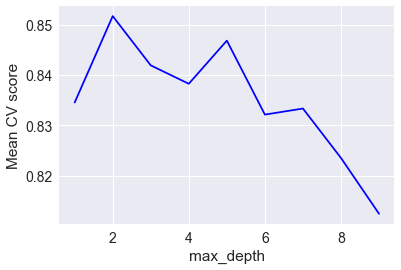

In [60]:
boost = GradientBoostingClassifier(random_state = 42)
prange=np.arange(1,10,1)
train_scores, cv_scores = validation_curve(boost, X_train, y_train ,param_name='max_depth',
                                              param_range=prange, scoring = 'accuracy')

plt.xlabel('max_depth')
plt.ylabel('Mean CV score')
plt.plot(prange, np.mean(cv_scores, axis=1), label="Cross-validation score",color="b")

In [61]:
boost_tune = GradientBoostingClassifier(random_state = 42, max_depth = prange[np.argmax(np.mean(cv_scores, axis=1))])
parameters_b_new = {'learning_rate': np.arange(0.01, 0.13, 0.02), 'n_estimators': np.arange(50,150, 20)}
boosting_tune = GridSearchCV(boost_tune, param_grid = parameters_b_new, scoring='accuracy', verbose = 2, cv = 5)
boosting_tune.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] learning_rate=0.01, n_estimators=50 .............................
[CV] .............. learning_rate=0.01, n_estimators=50, total=   0.0s
[CV] learning_rate=0.01, n_estimators=50 .............................
[CV] .............. learning_rate=0.01, n_estimators=50, total=   0.0s
[CV] learning_rate=0.01, n_estimators=50 .............................
[CV] .............. learning_rate=0.01, n_estimators=50, total=   0.0s
[CV] learning_rate=0.01, n_estimators=50 .............................
[CV] .............. learning_rate=0.01, n_estimators=50, total=   0.0s
[CV] learning_rate=0.01, n_estimators=50 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .............. learning_rate=0.01, n_estimators=50, total=   0.0s
[CV] learning_rate=0.01, n_estimators=70 .............................
[CV] .............. learning_rate=0.01, n_estimators=70, total=   0.1s
[CV] learning_rate=0.01, n_estimators=70 .............................
[CV] .............. learning_rate=0.01, n_estimators=70, total=   0.1s
[CV] learning_rate=0.01, n_estimators=70 .............................
[CV] .............. learning_rate=0.01, n_estimators=70, total=   0.1s
[CV] learning_rate=0.01, n_estimators=70 .............................
[CV] .............. learning_rate=0.01, n_estimators=70, total=   0.1s
[CV] learning_rate=0.01, n_estimators=70 .............................
[CV] .............. learning_rate=0.01, n_estimators=70, total=   0.1s
[CV] learning_rate=0.01, n_estimators=90 .............................
[CV] .............. learning_rate=0.01, n_estimators=90, total=   0.1s
[CV] learning_rate=0.01, n_estimators=90 .............................
[CV] .

[CV] .............. learning_rate=0.05, n_estimators=90, total=   0.1s
[CV] learning_rate=0.05, n_estimators=90 .............................
[CV] .............. learning_rate=0.05, n_estimators=90, total=   0.1s
[CV] learning_rate=0.05, n_estimators=110 ............................
[CV] ............. learning_rate=0.05, n_estimators=110, total=   0.1s
[CV] learning_rate=0.05, n_estimators=110 ............................
[CV] ............. learning_rate=0.05, n_estimators=110, total=   0.1s
[CV] learning_rate=0.05, n_estimators=110 ............................
[CV] ............. learning_rate=0.05, n_estimators=110, total=   0.1s
[CV] learning_rate=0.05, n_estimators=110 ............................
[CV] ............. learning_rate=0.05, n_estimators=110, total=   0.1s
[CV] learning_rate=0.05, n_estimators=110 ............................
[CV] ............. learning_rate=0.05, n_estimators=110, total=   0.1s
[CV] learning_rate=0.05, n_estimators=130 ............................
[CV] .

[CV] ............. learning_rate=0.09, n_estimators=130, total=   0.1s
[CV] learning_rate=0.09, n_estimators=130 ............................
[CV] ............. learning_rate=0.09, n_estimators=130, total=   0.1s
[CV] learning_rate=0.11, n_estimators=50 .............................
[CV] .............. learning_rate=0.11, n_estimators=50, total=   0.0s
[CV] learning_rate=0.11, n_estimators=50 .............................
[CV] .............. learning_rate=0.11, n_estimators=50, total=   0.0s
[CV] learning_rate=0.11, n_estimators=50 .............................
[CV] .............. learning_rate=0.11, n_estimators=50, total=   0.0s
[CV] learning_rate=0.11, n_estimators=50 .............................
[CV] .............. learning_rate=0.11, n_estimators=50, total=   0.0s
[CV] learning_rate=0.11, n_estimators=50 .............................
[CV] .............. learning_rate=0.11, n_estimators=50, total=   0.0s
[CV] learning_rate=0.11, n_estimators=70 .............................
[CV] .

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   10.1s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': array([ 0.01,  0.03,  0.05,  0.07,  0.09,  0.11]), 'n_estimators': array([ 50,  70,  90, 110, 130])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [62]:
print(boosting_tune.cv_results_['mean_test_score'][boosting_tune.best_index_])
print(boosting_tune.cv_results_['std_test_score'][boosting_tune.best_index_])

0.850490196078
0.0191822808961


In [63]:
y_predict_boosting_tune_r = boosting_tune.predict(X_test)
print('accuracy', accuracy_score(y_test, y_predict_boosting_tune_r))
conf_mat = pd.DataFrame(confusion_matrix(y_predict_boosting_tune_r, y_test))
conf_mat

accuracy 0.871428571429


,0,1
0,151,29
1,16,154


In [64]:
#stacked model

def cross_val_model(model, X, y, verbose=2):
    cv = KFold(n_splits=5)
    scores = cross_val_score(model, X, y, cv=cv, verbose=verbose, scoring='accuracy')
    print('{}: {:.3f}±{:.3f}'.format(model.__class__.__name__, np.mean(scores), np.std(scores)))

boost = GradientBoostingClassifier(random_state = 42)
boost.fit(X_train, y_train)
combo = pd.DataFrame({'forest': forest_tune.predict_proba(X_test)[:, 1], 
                      'svm': svm_new.predict_proba(X_test)[:, 1], 
                      'boost': boosting_tune.predict_proba(X_test)[:, 1]})
cross_val_model(boost, combo, y_test, 0)

def cross_val_model_new(model, X_reduce, y, verbose=2):
    cv = KFold(n_splits=5)
    scores = cross_val_score(model, X_reduce, y, cv=cv, verbose=verbose, scoring='accuracy')
    return (np.mean(scores))

GradientBoostingClassifier: 0.860±0.029


In [65]:
print('Choosen metric is accuracy')
print('NN without reducing features: {:.3f}'.format(np.mean(scores_red), np.std(scores_red)))
print('Random forest without reducing features: {:.3f}'.format(accuracy_score(y_test, y_predict_forest_tune_r)))
print('Xgboost without reducing features: {:.3f}'.format(accuracy_score(y_test, y_predict_boosting_tune_r)))
print('SVM without reducing features: {:.3f}'.format(accuracy_score(y_test, y_predict_svm_tune_r)))
print('Stacked model without reducing features: {:.3f}'.format(cross_val_model_new(boost, combo, y_test, 0)))

print('----------------------------------------------------------------')
print('Neural network from the article: {:.3f}'.format(np.mean(scores), np.std(scores)))
print('Random forest: {:.3f}'.format(accuracy_score(y_test, y_predict_forest_tune)))
print('Xgboost: {:.3f}'.format(accuracy_score(y_test, y_predict_boosting_tune)))
print('SVM: {:.3f}'.format(accuracy_score(y_test, y_predict_svm_tune)))
print('Stacked model', 0.829)

Choosen metric is accuracy
NN without reducing features: 0.829
Random forest without reducing features: 0.840
Xgboost without reducing features: 0.871
SVM without reducing features: 0.800
Stacked model without reducing features: 0.860
----------------------------------------------------------------
Neural network from the article: 0.827
Random forest: 0.849
Xgboost: 0.860
SVM: 0.834
Stacked model 0.829


##### So, Xgboost is the best choice. 
##### Network from the article worked worse, than with dataset from article.
##### So, we can made a conclusion, that the success of neural network in the article can not be generalized for such type of tasks.
##### Feature reduction decreased and increased accuracy for different models, but result is around the same. However, we prefer 5-dimensional model: simple models are more preferable and interpret (for example AIC criterion)